# CANDLE and DLHub

This notebook shows how DLHub can be used to work with ECP-CANDLE models. We first use the DLHubClient to discover existing models. Then we use the client to initiate a publication request of a pre-trained P1B1 model. Finally, we perform on-demand inference of both the P1B1 and Combo models that are published in DLHub.

In [68]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import os

Use the DLHub SDK to create a DLHubClient. The DLHubCLient wraps both our REST API and Search catalog. You can use the client to publish, discover, and use models.

In [69]:
import dlhub_sdk
dl = dlhub_sdk.DLHubClient()

DLHub uses a custom metadata schema to encode models. This metadata describes the inputs, outputs, type, and author information. While we provider helper functions to aid in its creation, you can see the structure

In [70]:
df_serv = dl.search_by_servable(servable_name="candle*")
df_serv[0]

{'datacite': {'alternateIdentifiers': [{'alternateIdentifier': 'https://github.com/ECP-CANDLE/Benchmarks/tree/release_01/Pilot1/P1B1',
    'alternateIdentifierType': 'URL'}],
  'creators': [{'affiliations': 'CANDLE',
    'familyName': 'Team',
    'givenName': 'CANDLE'}],
  'descriptions': [{'description': 'CANDLE pilot 1 benchmark 1 model.',
    'descriptionType': 'Abstract'}],
  'identifier': {'identifier': '10.YET/UNASSIGNED', 'identifierType': 'DOI'},
  'publicationYear': '2019',
  'publisher': 'DLHub',
  'resourceType': {'resourceTypeGeneral': 'InteractiveResource'},
  'titles': [{'title': 'CANDLE P1B1 Demo1'}]},
 'dlhub': {'build_location': '/mnt/dlhub_ingest/037c8768-45fd-4466-aa53-95d2044ae14f',
  'domains': ['genomics', 'cancer research'],
  'ecr_arn': 'arn:aws:ecr:us-east-1:039706667969:repository/037c8768-45fd-4466-aa53-95d2044ae14f',
  'ecr_uri': '039706667969.dkr.ecr.us-east-1.amazonaws.com/037c8768-45fd-4466-aa53-95d2044ae14f',
  'files': {'model': 'p1b1.h5'},
  'id': '037

# Publishing Models

To publish a model with DLHub we first gather some metadata about the model itself. Our SDK is designed to assist the user in generating this metadata.

This example shows how to use the DLHub SDK to:
- Using the SDK to automatically extract metadata from a Keras model.
- Describing additional metadata about the model
- Publishing the model

## Publishing a P1B1 model.

I've trained a simple version of the P1B1 model using the code found here:

https://github.com/ECP-CANDLE/Benchmarks/tree/master/Pilot1/P1B1

The resulting model has been exported as "p1b1.h5" and is in the current working directory:

In [71]:
!ls -tho

total 3.9G
-rw-r--r-- 1 rchard  46K Feb 28 19:41 CANDLE-DLHub-demo.ipynb
-rw-r--r-- 1 rchard  37K Feb 28 16:00 CANDLE-DLHub-example.ipynb
-rw-r--r-- 1 rchard  29K Feb 27 01:30 CANDLE-dlhub-publish.ipynb
drwx------ 2 rchard  512 Feb 25 21:01 __pycache__
-rw-r--r-- 1 rchard  497 Feb 25 21:00 dropout_layer.py
-rwxr-xr-x 1 rchard 2.4M Feb 25 19:24 pilot1.npy
-rw-r--r-- 1 rchard 1.9G Feb 25 17:28 p1b1.h5
-rw-r--r-- 1 rchard  53M Jan 26  2018 saved.weights.h5
-rw-r--r-- 1 rchard  53M Jan 26  2018 saved.model.h5


The first step to describing the model is to use the SDK to create a model object. In the case of Keras, the model object is able bootstrap the metadata by loading the trained model and automatically extracting metadata regarding its structure.

In [72]:
from dlhub_sdk.models.servables.keras import KerasModel
import pickle as pkl
import json

# Describe the keras model
model_info = KerasModel.create_model('p1b1.h5', list(map(str, range(10))))

Now we use the SDK to append other metadata to the model. Below we set the name of the model, dependencies, and describe additional metadata for search purposes.

In [73]:
# Describe the model
model_info.set_title("CANDLE P1B1 Demo2")
model_info.set_name("candle_p1b1_demo2")
model_info.set_domains(["genomics","cancer research"])

# Add dependencies
model_info.add_requirement('keras', 'detect')
model_info.add_requirement('numpy', 'detect')

# Describe the outputs in more detail
model_info['servable']['methods']['run']['output']['description'] = 'Output'
model_info['servable']['methods']['run']['input']['description'] = 'Input'

# Add provenance information
model_info.set_authors(["Team, CANDLE"], ["CANDLE"])
model_info.set_abstract("CANDLE pilot 1 benchmark 1 model.")
model_info.add_alternate_identifier("https://github.com/ECP-CANDLE/Benchmarks/tree/release_01/Pilot1/P1B1", "URL")

Now the metadata is created we can use it to publish the model.

In [74]:
# Print out the result
print(json.dumps(model_info.to_dict(), indent=2))

{
  "datacite": {
    "creators": [
      {
        "givenName": "CANDLE",
        "familyName": "Team",
        "affiliations": "CANDLE"
      }
    ],
    "titles": [
      {
        "title": "CANDLE P1B1 Demo2"
      }
    ],
    "publisher": "DLHub",
    "publicationYear": "2019",
    "identifier": {
      "identifier": "10.YET/UNASSIGNED",
      "identifierType": "DOI"
    },
    "descriptions": [
      {
        "description": "CANDLE pilot 1 benchmark 1 model.",
        "descriptionType": "Abstract"
      }
    ],
    "fundingReferences": [],
    "relatedIdentifiers": [],
    "alternateIdentifiers": [
      {
        "alternateIdentifier": "https://github.com/ECP-CANDLE/Benchmarks/tree/release_01/Pilot1/P1B1",
        "alternateIdentifierType": "URL"
      }
    ],
    "rightsList": [],
    "resourceType": {
      "resourceTypeGeneral": "InteractiveResource"
    }
  },
  "dlhub": {
    "version": "0.6.1",
    "domains": [
      "genomics",
      "cancer research"
    ],
    "vis

Here we use the SDK to directly publish the model using the model object. This process will first take each of the files listed in "files" block and create a temporary tar file. The tar file is then transmitted to the DLHub service (via a multipart POST request) and the JSON document is used to guide a publication pipeline. 

The publication process includes:
- Creating a temporary tar of the files specified in the above JSON
- Transmit the tar file to the DLHub service using a multipart POST request
- Start a server-side flow to:
    - Use the specified dependencies to create a docker container of the model
    - Push a copy of the container to AWS ECR
    - Ingest the metadata into the search index

We could also save the above JSON document and use it to publish the model via our CLI or through our GitHub-based repo2docker pipeline.

In [9]:
task_id = dl.publish_servable(model_info)

In [10]:
task_id

'751011ef-d4ab-4455-b24b-dd24cdaa6d44'

# Running models

Below shows how to use the DLHub SDK to invoke the P1B1 model published in DLHub.

I have taken a subset of the data available on the CANDLE FTP site and placed it in a local file called "pilot1.npy".

In [75]:
test_data = np.load("pilot1.npy")

In [76]:
print(test_data)
print("There are {0} entries in the dataset. Each entry has {1} values.".format(len(test_data), len(test_data[0])))

[[0.8681818  0.32765958 0.88584477 ... 0.         0.         0.        ]
 [0.8545454  0.4638298  0.8584475  ... 0.         0.         0.        ]
 [0.83181816 0.         0.9086758  ... 0.         0.         0.        ]
 ...
 [0.8454546  0.5702127  0.86757994 ... 0.         0.         0.        ]
 [0.84090906 0.4595745  0.8995434  ... 0.         0.         0.        ]
 [0.8363636  0.39148936 0.8538813  ... 0.         0.         0.        ]]
There are 10 entries in the dataset. Each entry has 60483 values.


Now we need to find the model's name. I have previously published one called: "candle_p1b1_demo1"

In [77]:
df_serv = dl.search_by_servable(servable_name="candle_p1b1_demo1")
servable_name = df_serv[0]['dlhub']['shorthand_name']
servable_name

'ryan_globusid/candle_p1b1_demo1'

In [78]:
p1b1_preds = []
for data in test_data.tolist():
    pred = dl.run(servable_name, [data], input_type='python')
    p1b1_preds.append(np.array(pred))
    break

In [79]:
p1b1_preds

[array([[0.82595909, 0.32600409, 0.878483  , ..., 0.01652291, 0.01677323,
         0.01659214]])]

In [80]:
len(p1b1_preds[0][0])

60483

# Publishing and Using Pilot 1: Combo

Here is another example that uses the SDK to markup, publish, and use the Combo model. This example is a little different as the trained model is provided as two files: a set of weights and an architecture file.

The Combo model also requires a custom dropout layer. We have extended the Keras model loader to support this. However, the metadata describing the model must indicate that the custom layer is necessary and the layer needs to be shipped along with the model itself to create the servable.

In [81]:
from dlhub_sdk.models.servables.keras import KerasModel
from dropout_layer import PermanentDropout
import pickle as pkl
import json
# Describe the keras model
model_info = KerasModel.create_model('saved.weights.h5', list(map(str, range(10))), 
                                     arch_path="saved.model.h5", 
                                     custom_objects={"PermanentDropout": PermanentDropout})

In [82]:
# Describe the model
model_info.set_title("CANDLE Pilot1 Combo Demo2")
model_info.set_name("candle_p1_combo_demo2")
model_info.set_domains(["genomics","cancer research"])

# Add dependencies
model_info.add_requirement('keras', 'detect')
model_info.add_requirement('numpy', 'detect')

# Add dropout layer file
model_info.add_file("dropout_layer.py")

# Describe the outputs in more detail
model_info['servable']['methods']['run']['output']['description'] = 'Output'
model_info['servable']['methods']['run']['input']['description'] = 'Input'

# Add provenance information
model_info.set_authors(["Team, CANDLE"], ["CANDLE"])
model_info.set_abstract("CANDLE pilot 1 combo model.")
model_info.add_alternate_identifier("https://github.com/ECP-CANDLE/Benchmarks/tree/master/Pilot1/Combo", "URL")

In [83]:
print(json.dumps(model_info.to_dict(), indent=2))

{
  "datacite": {
    "creators": [
      {
        "givenName": "CANDLE",
        "familyName": "Team",
        "affiliations": "CANDLE"
      }
    ],
    "titles": [
      {
        "title": "CANDLE Pilot1 Combo Demo2"
      }
    ],
    "publisher": "DLHub",
    "publicationYear": "2019",
    "identifier": {
      "identifier": "10.YET/UNASSIGNED",
      "identifierType": "DOI"
    },
    "descriptions": [
      {
        "description": "CANDLE pilot 1 combo model.",
        "descriptionType": "Abstract"
      }
    ],
    "fundingReferences": [],
    "relatedIdentifiers": [],
    "alternateIdentifiers": [
      {
        "alternateIdentifier": "https://github.com/ECP-CANDLE/Benchmarks/tree/master/Pilot1/Combo",
        "alternateIdentifierType": "URL"
      }
    ],
    "rightsList": [],
    "resourceType": {
      "resourceTypeGeneral": "InteractiveResource"
    }
  },
  "dlhub": {
    "version": "0.6.1",
    "domains": [
      "genomics",
      "cancer research"
    ],
    "visi

In [10]:
task_id = dl.publish_servable(model_info)

In [11]:
task_id

'fb87e5e4-b07b-4b26-a7c1-533e7799bd97'

## Running the Combo model

I'm not actually sure what data this thing takes, but the model summary states that there are three inputs:

input.cell.expression (InputLay (None, 942)<br>
input.drug1.descriptors (InputL (None, 3820)<br>
input.drug2.descriptors (InputL (None, 3820)<br>

Therefore we can create example input to ensure the model is running correctly.

In [84]:
servable_desc = dl.describe_servable('ryan_globusid', 'candle_p1_combo_demo1')
print(servable_desc['servable']['model_summary'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input.cell.expression (InputLay (None, 942)          0                                            
__________________________________________________________________________________________________
input.drug1.descriptors (InputL (None, 3820)         0                                            
__________________________________________________________________________________________________
input.drug2.descriptors (InputL (None, 3820)         0                                            
__________________________________________________________________________________________________
cell.expression (Model)         (None, 1000)         2945000     input.cell.expression[0][0]      
__________________________________________________________________________________________________
drug.descr

The servable description also contains more succinct description of the inputs

In [85]:
servable_desc['servable']['methods']['run']['input']

{'description': 'Input',
 'element_types': [{'description': 'Tensor',
   'shape': ['None', '942'],
   'type': 'ndarray'},
  {'description': 'Tensor', 'shape': ['None', '3820'], 'type': 'ndarray'},
  {'description': 'Tensor', 'shape': ['None', '3820'], 'type': 'ndarray'}],
 'type': 'tuple'}

The client also provides a shortcut for accessing the input descriptions, as we anticipate that being a common need

In [86]:
dl.describe_methods('ryan_globusid', 'candle_p1_combo_demo1', 'run')

{'input': {'description': 'Input',
  'element_types': [{'description': 'Tensor',
    'shape': ['None', '942'],
    'type': 'ndarray'},
   {'description': 'Tensor', 'shape': ['None', '3820'], 'type': 'ndarray'},
   {'description': 'Tensor', 'shape': ['None', '3820'], 'type': 'ndarray'}],
  'type': 'tuple'},
 'output': {'description': 'Output',
  'shape': ['None', '1'],
  'type': 'ndarray'}}

Given this information, we can create inputs in the proper format and use them to run the model

In [87]:
combo_input = [np.zeros((200, 942)).tolist(), 
               np.zeros((200, 3820)).tolist(), 
               np.zeros((200, 3820)).tolist()]

In [88]:
res = dl.run('ryan_globusid/candle_p1_combo_demo1', combo_input, input_type='json')

Text(0, 0.5, 'Frequency')

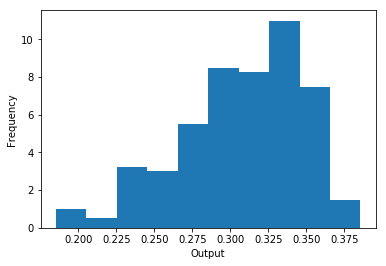

In [89]:
fig, ax = plt.subplots()

ax.hist(np.ravel(res), density=True)

ax.set_xlabel('Output')
ax.set_ylabel('Frequency')

The distribution of the outputs has a non-zero variance, as expected given that the "p1_combo" model contains a dropout layer that is still active on predictions.

In [93]:
res_test = dl.run('ryan_globusid/noop', [1,2,3], input_type='json')

In [94]:
res_test

{}